# BL40A2020 Wireless Communication Systems

## Assignment  week 5: Optimal demodulation

## Author: Jesse Peltola

### Follow the steps done in the [notes](https://github.com/pedrohjn/wireless-comm/blob/master/Week%205/week5.ipynb) to analyze the *[8PSK](https://komm.readthedocs.io/en/latest/komm.PSKModulation/)* modulation

**1. Signal constelation with noise for $E_b/N_0 = 12$dB. You can reuse the code provided in this [link](https://github.com/rwnobrega/komm/blob/master/demo/constellations.ipynb).**

In [2]:
import math
import komm
import sympy as sp
from sympy.stats import Normal, density, E, std, cdf
sp.init_printing() 
import scipy.signal as signal
import scipy.fftpack as fftpack
import scipy.interpolate as interp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')
import warnings
warnings.filterwarnings('ignore')


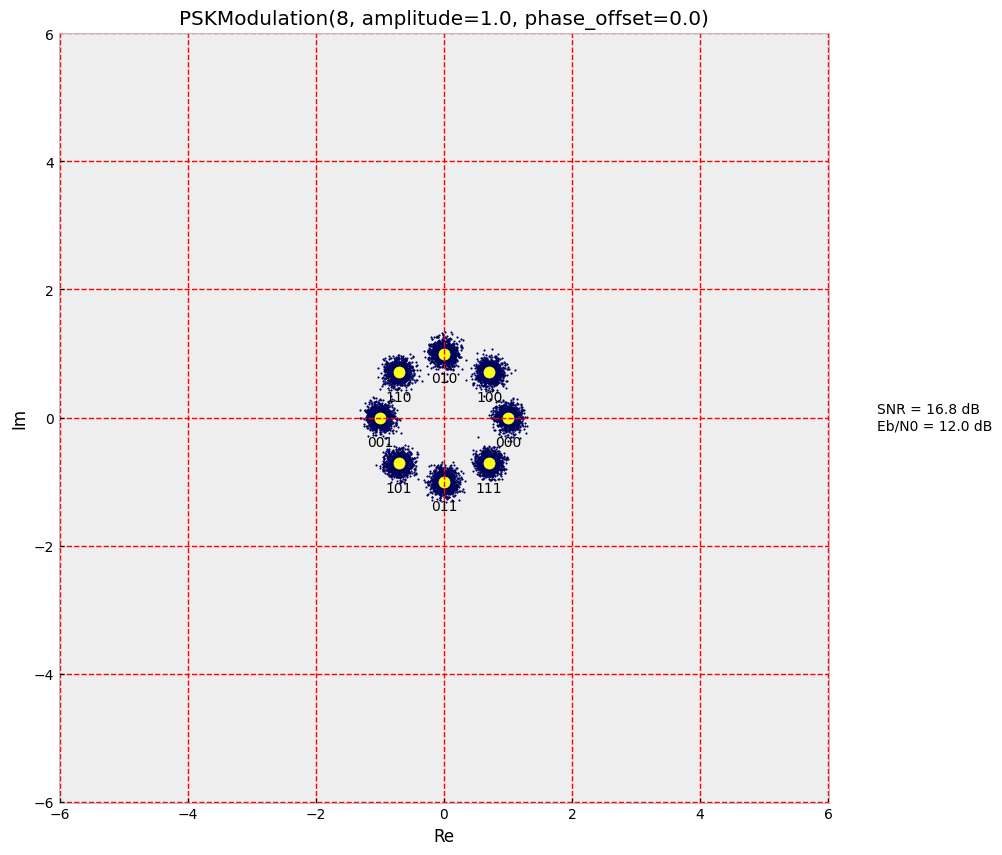

In [19]:
def constellation_demo(modulation, noise_power_db, xlim, ylim):
    awgn = komm.AWGNChannel()

    num_symbols = 10000
    noise_power = 10**(noise_power_db / 10)
    awgn.signal_power = modulation.energy_per_symbol
    awgn.snr = awgn.signal_power / noise_power
    num_bits = modulation.bits_per_symbol * num_symbols
    bits = np.random.randint(2, size=num_bits)
    sentword = modulation.modulate(bits)
    recvword = awgn(sentword)

    _, ax = plt.subplots(figsize=(16, 10))
    ax.scatter(recvword.real, recvword.imag, color='xkcd:dark blue', s=1)
    ax.scatter(modulation.constellation.real, modulation.constellation.imag, color='xkcd:yellow', s=8**2)
    for (i, point) in enumerate(modulation.constellation):
        binary_label = ''.join(str(b) for b in komm.int2binlist(modulation.labeling[i], width=modulation.bits_per_symbol))
        ax.text(point.real, point.imag + 0.075 * xlim[0], binary_label, horizontalalignment='center')
    ax.set_title(repr(modulation))
    ax.set_xlabel('Re')
    ax.set_ylabel('Im')
    ax.axis('square')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid(color='r', linestyle='--', linewidth=1)
    info_text = 'SNR = {:.1f} dB\n'.format(10*np.log10(awgn.snr))
    info_text += 'Eb/N0 = {:.1f} dB'.format(10*np.log10(awgn.snr / modulation.bits_per_symbol))
    ax.text(1.125 * xlim[1], 0.0, info_text, horizontalalignment='left', verticalalignment='center')
    plt.show()
    
#To get the static figure for saving as pdf
order = 8
base_amplitude=1
phase_offset=0
labeling='natural'
noise_power_db=-16.8

psk_modulation = komm.PSKModulation(order, base_amplitude, phase_offset, labeling)
lim = [-2.125*np.sqrt(order), 2.125*np.sqrt(order)]
constellation_demo(psk_modulation, noise_power_db, xlim=lim, ylim=lim)

**2. Numerical example:** Assume the following equation:

$$u_\mathrm{p}(t) = u_\mathrm{c}(t)\cos(2\pi 600 t) - u_\mathrm{s}(t)\sin(2\pi 600 t)$$

Considering an AWGN channel so that $E_b/N_0 = 12$dB, plot the wave form for a random binary sequence of $18$ bits considering an information rate of 300 bits per second.

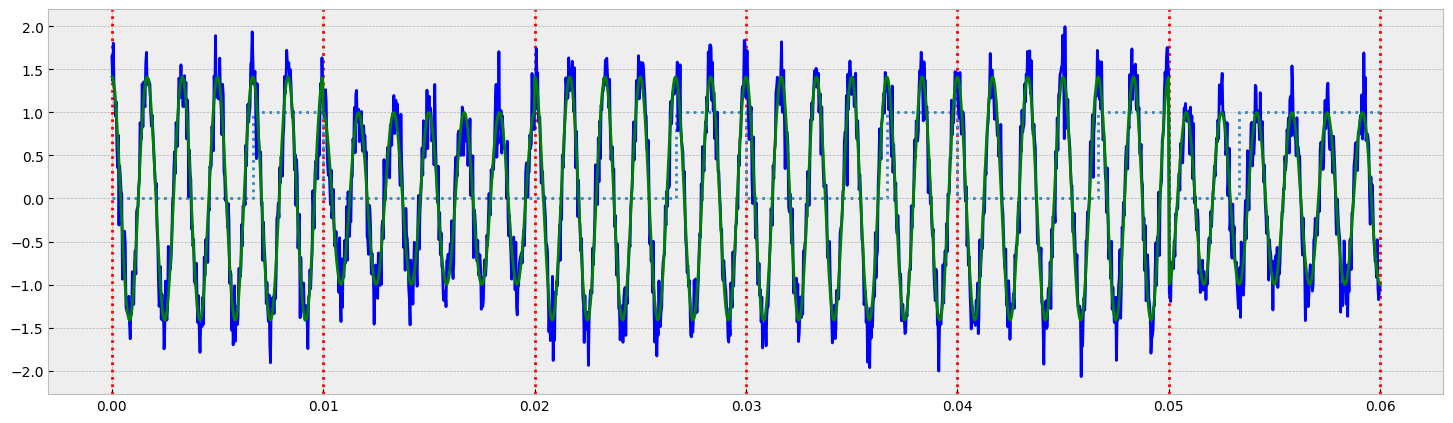

In [21]:
M = 8



#Es = 1, N0 = 0.06 = -12dB, N0 = 2pi2 = pi = 0.17

psk = komm.PSKModulation(M)

observations = int
observations = 6
rate = 300
input_seq_size = observations * np.log2(M).astype(int)
time_of_obs = input_seq_size/rate
tp = np.arange(0, input_seq_size, 1)/rate
input_seq = np.random.randint(2, size=input_seq_size)
input_seq_plot = np.append(input_seq, input_seq[input_seq_size-1])
tp_plot = np.append(tp, tp[input_seq_size-1]+1/rate)


samples = 100
tmod_points = samples * input_seq_size
tmod = np.linspace(0, tp_plot[input_seq_size], tmod_points)

input_wave_aux = psk.modulate(input_seq)
input_wave_I = np.zeros(tmod_points)
input_wave_Q = np.zeros(tmod_points)

for i in range(0, tmod_points):
    aux = math.floor(i/(samples * np.log2(M)))
    for j in range(M):
        if np.around(input_wave_aux[aux], decimals=3) == np.around(psk.constellation[j], decimals=3):
            input_wave_I[i] = psk.constellation[j].real
            input_wave_Q[i] = psk.constellation[j].imag
t, fc = sp.symbols("t, f_c")
uc = sp.cos(2*sp.pi*600*t)
us = sp.cos(2*sp.pi*600*t)

modulation_I = sp.lambdify(t, uc, "numpy")
modulation_Q = sp.lambdify(t, us, "numpy")

plt.rcParams['figure.figsize'] = 18, 5

for i in range(observations + 1):
    plt.axvline(i * np.log2(M)/rate, linestyle=":", color="r")



plt.step(tp_plot, input_seq_plot, where='post', linestyle=':')

mu, sigma = 0, 0.17 #was calculated, mean and standard deviation

noiseQ = np.random.normal(mu, sigma, tmod_points)
noiseI = np.random.normal(mu, sigma, tmod_points)
plt.plot(tmod,(input_wave_I*modulation_I(tmod) + noiseI) - (input_wave_Q*modulation_Q(tmod) + noiseQ),'b')

plt.plot(tmod, input_wave_I * modulation_I(tmod) - input_wave_Q* modulation_Q(tmod), 'g')
plt.show()



**3. Performance analysis:** Plot the figure *error probability vs. $E_b/N_0$* assuming that the 0's and 1's in the input sequence are equally distributed. Consider two curves, symbol error probability and bit error probability.

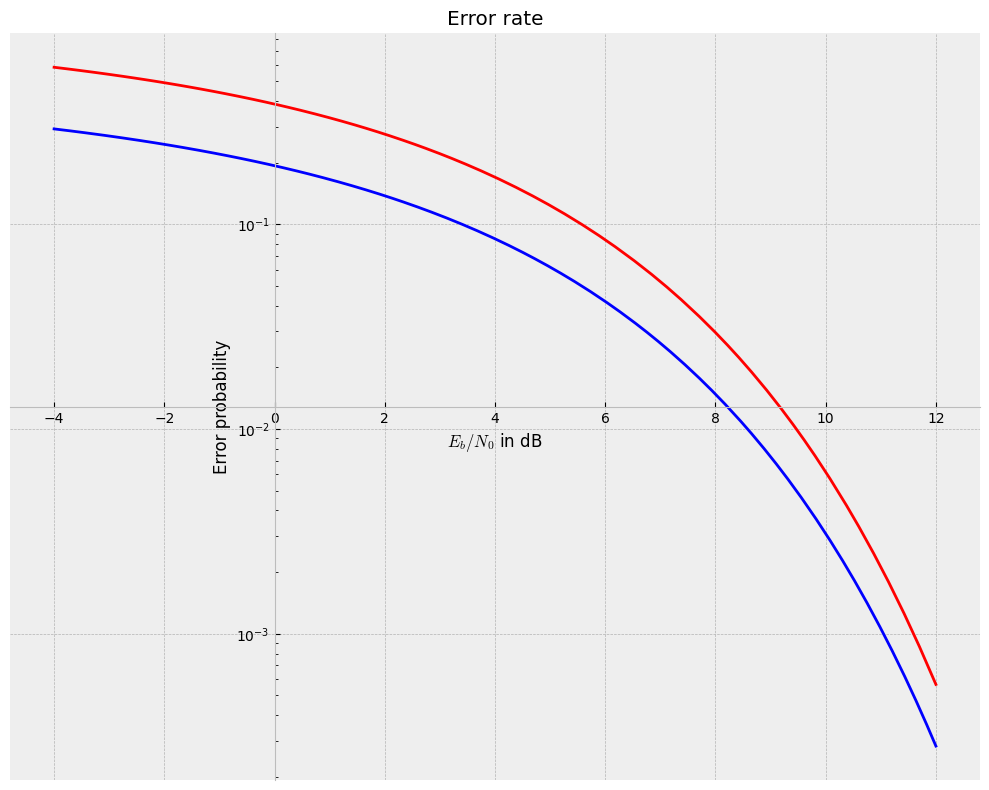

In [30]:
#For the 8PSK, d_min = 1, N_d_min = 2, energy per symbol E_s = 1, Energy per bit E_b = 1/3, E_b/N_0 = 1/(3N_0) = 1/(6sigma^2)

def Q(x):
    return sp.simplify(1/2 * sp.erfc(x/sp.sqrt(2)))

y = sp.Symbol("y")

plt.rcParams['figure.figsize'] = 10, 8

plt_aux = sp.plot(sp.N(2*Q(sp.sqrt(3/4 * 10 **(y/10)))), sp.N(Q(sp.sqrt(3/4 *10**(y/10)))), (y, -4, 12), xlabel='$E_b/N_0$ in dB',ylabel='Error probability', yscale= 'log', title='Error rate',show=False);
plt_aux[0].line_color = 'r'
plt_aux[1].line_color = 'b'
plt_aux.show()



**4. Decision rule:** If the input sequence is not equally distributed, the optimal decision rule changes. With your own words, explain why MAP outperforms ML.

In the context of communication systems or signal processing, MAP (Maximum A Posteriori) and ML (Maximum Likelihood) are decision rules used to make decisions about the transmitted symbols based on the received signals. The choice between MAP and ML depends on the characteristics of the communication channel and the type of noise affecting the received signals.

If the input sequence is not uniformly distributed, i.e., if certain symbols are more likely than others, MAP is better than ML because MAP not only takes into account the probability of the observed data at each possible transmitted symbol (like ML), but also incorporates prior probabilities of the symbols.

MAP takes into account prior probabilities by applying Bayes' theorem. It takes into account the a priori probability of each possible symbol in addition to the probability of observing the received signal at each symbol. This additional information is crucial when the symbols are not equally likely.

In contrast, ML makes decisions based solely on the probability of the observed data without considering prior information about the probabilities of the different symbols. If the input sequence is not uniformly distributed, ML can be more prone to error because it does not take into account the prior probabilities of the symbols.

To summarise, MAP outperforms ML when the input sequence is not uniformly distributed, as it takes into account both the probability of the observed data and the prior probabilities of the symbols and provides a more robust decision rule in situations where certain symbols are more likely to be transmitted than others.